In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
import pandas as pd

In [3]:
import shapefile

Let's read the shapefile for the 2010 census districts:

In [4]:
reader = shapefile.Reader("../data/gz_2010_47_140_00_500k.shp")

Here are all the fields with information:

In [7]:
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

In [8]:
fields

[['GEO_ID', 'C', 60, 0],
 ['STATE', 'C', 2, 0],
 ['COUNTY', 'C', 3, 0],
 ['TRACT', 'C', 6, 0],
 ['NAME', 'C', 90, 0],
 ['LSAD', 'C', 7, 0],
 ['CENSUSAREA', 'N', 31, 15]]

In [9]:
field_names

['GEO_ID', 'STATE', 'COUNTY', 'TRACT', 'NAME', 'LSAD', 'CENSUSAREA']

In [10]:
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
        geometry=geom, properties=atr)) 


In [98]:
buffer[:10]

[{'geometry': {'coordinates': (((-88.241677, 35.423263),
     (-88.241951, 35.418654),
     (-88.2461, 35.418817),
     (-88.246192, 35.416306999999996),
     (-88.25003699999999, 35.4165),
     (-88.315624, 35.41796),
     (-88.360829, 35.418972),
     (-88.36259, 35.458554),
     (-88.364004, 35.492801),
     (-88.375022, 35.49314),
     (-88.376356, 35.493111999999996),
     (-88.37771, 35.492608),
     (-88.385081, 35.552569999999996),
     (-88.38909199999999, 35.580759),
     (-88.385494, 35.580438),
     (-88.383932, 35.581261999999995),
     (-88.380842, 35.584959),
     (-88.37919099999999, 35.589959),
     (-88.371566, 35.594296),
     (-88.36845699999999, 35.595656999999996),
     (-88.36792, 35.596213999999996),
     (-88.364503, 35.599934999999995),
     (-88.361755, 35.605711),
     (-88.35506, 35.606923),
     (-88.34894299999999, 35.60753),
     (-88.34716, 35.607051999999996),
     (-88.34616, 35.602621),
     (-88.34445699999999, 35.600303),
     (-88.33943699999999, 

In [11]:
# write the GeoJSON file
from json import dumps
geojson = open("../data/gz_2010_47_140_00_500k.json", "w")
geojson.write(dumps({"type": "FeatureCollection",\
"features": buffer}, indent=2) + "\n")
geojson.close()

Let's make a function for future use:

In [12]:
def convert_to_json(namestr):
    reader = shapefile.Reader(namestr+ ".shp")
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]
    
    buffer = []
    for sr in reader.shapeRecords():
        atr = dict(zip(field_names, sr.record))
        geom = sr.shape.__geo_interface__
        buffer.append(dict(type="Feature", \
            geometry=geom, properties=atr)) 

    # write the GeoJSON file
    from json import dumps
    geojson = open(namestr+".json", "w")
    geojson.write(dumps({"type": "FeatureCollection",\
    "features": buffer}, indent=2) + "\n")
    geojson.close()
    
    return

Awesome, let's try to plot that:

In [153]:
import geojson

In [14]:
census_tracts = geojson.load(open("../data/gz_2010_47_140_00_500k.json"))

In [15]:
feat = census_tracts["features"]

In [16]:
f = feat[0]

In [17]:
f.keys()

dict_keys(['type', 'properties', 'geometry'])

In [18]:
geo_id = [f["properties"]["GEO_ID"] for f in feat]
name = [f["properties"]["NAME"] for f in feat]
tract = [f["properties"]["TRACT"] for f in feat]

In [19]:
geo_id[:10]

['1400000US47077975500',
 '1400000US47079969400',
 '1400000US47081950500',
 '1400000US47083120100',
 '1400000US47085130400',
 '1400000US47089070300',
 '1400000US47091956400',
 '1400000US47093000100',
 '1400000US47093001600',
 '1400000US47093002300']

In [20]:
name[:10]

['9755', '9694', '9505', '1201', '1304', '703', '9564', '1', '16', '23']

In [21]:
tract[:10]

['975500',
 '969400',
 '950500',
 '120100',
 '130400',
 '070300',
 '956400',
 '000100',
 '001600',
 '002300']

In [22]:
coords = np.array([np.array(f["geometry"]["coordinates"][0]) for f in feat])

In [23]:
for i,l in enumerate(coords):
    if len(l.shape) > 2:
        print(i)
        print(len(l.shape))

79
3
955
3
1377
3
1480
3


In [24]:
coords[79] = coords[79][0]
coords[955] = coords[955][0]
coords[1377] = coords[1377][0]
coords[1480] = coords[1480][0]

In [25]:
lat = np.concatenate([c[:, 1] for c in coords])
lng = np.concatenate([c[:, 0] for c in coords])

In [26]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [27]:
df_poly = pd.DataFrame({
                        'poly':[Polygon(np.array(c), True, edgecolor="k") for c in coords],
                        'label':tract,
                        'count': np.random.uniform(size=len(coords))
})

Let's make a function out of that, too:

In [28]:
def import_census_data(filename):
    census_tracts = geojson.load(open(filename))
    
    feat = census_tracts["features"]
    geo_id = [f["properties"]["GEO_ID"] for f in feat]
    name = [f["properties"]["NAME"] for f in feat]
    tract = [f["properties"]["TRACT"] for f in feat]
    
    coords = np.array([np.array(f["geometry"]["coordinates"][0]) for f in feat])
    
    for i,l in enumerate(coords):
        if len(l.shape) > 2:            
            coords[i] = coords[i][0]

    lat = np.concatenate([c[:, 1] for c in coords])
    lng = np.concatenate([c[:, 0] for c in coords])
    
    df_poly = pd.DataFrame({
                        'poly':[Polygon(np.array(c), True, edgecolor="k") for c in coords],
                        'tract':tract,
                        'geo_id': geo_id,
                        'name': name,
                        'count': np.random.uniform(size=len(coords))
    })
    
    return df_poly, lat, lng

In [29]:
df_poly, lat, lng = import_census_data("../data/gz_2010_47_140_00_500k.json")

In [30]:
import matplotlib

<IPython.core.display.Javascript object>


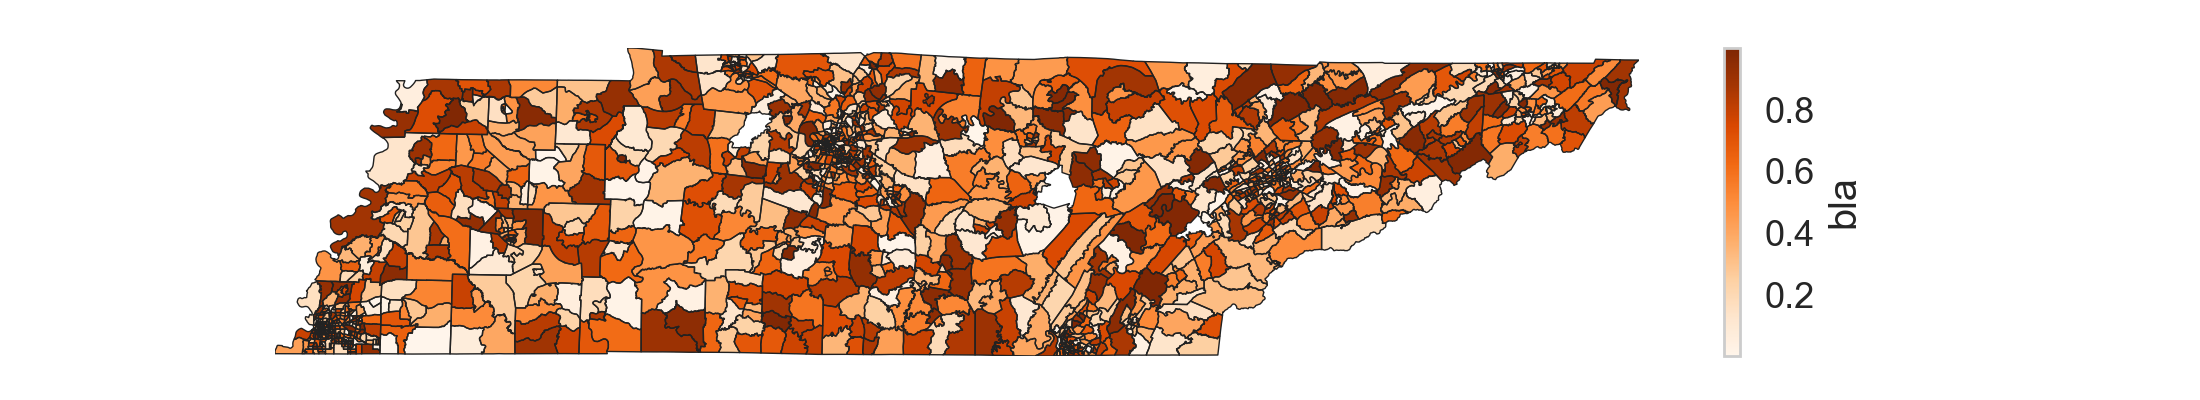

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(11, 2))

pc = PatchCollection(df_poly.poly, zorder=2)
cmap = plt.get_cmap('Oranges')   
norm = Normalize()
pc.set_facecolor(cmap(norm(df_poly['count'].fillna(0).values)))
pc.set_edgecolor("none")
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(df_poly['count'])
cbar = fig.colorbar(mapper, label="bla")

pc = PatchCollection(df_poly.poly, zorder=2)
pc.set_edgecolor("#222222")
pc.set_facecolor("none")
pc.set_linewidth(0.5)
ax.add_collection(pc)

ax.set_xlim(lng.min(), lng.max())
ax.set_ylim(lat.min(), lat.max())
plt.axis("off");



## Hamilton County Only

In [32]:
convert_to_json("../data/HamiltonCounty_ct_2010")

In [33]:
ham_df, ham_lat, ham_lng = import_census_data("../data/HamiltonCounty_ct_2010.json")

<IPython.core.display.Javascript object>


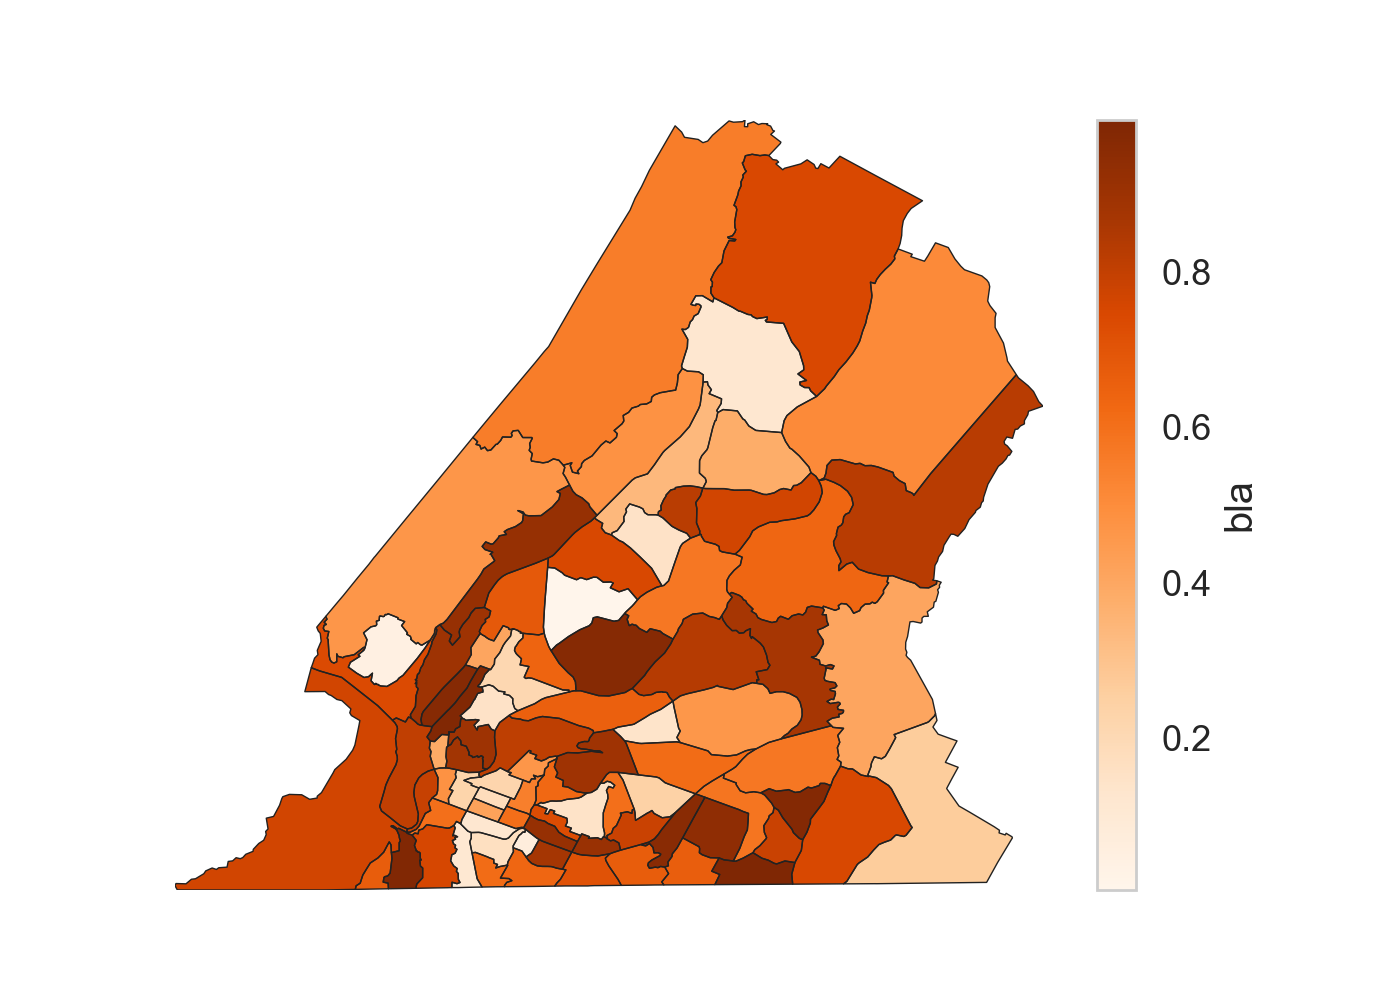

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pc = PatchCollection(ham_df.poly, zorder=2)
cmap = plt.get_cmap('Oranges')   
norm = Normalize()
pc.set_facecolor(cmap(norm(ham_df['count'].fillna(0).values)))
pc.set_edgecolor("none")
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(ham_df['count'])
cbar = fig.colorbar(mapper, label="bla")

pc = PatchCollection(ham_df.poly, zorder=2)
pc.set_edgecolor("#222222")
pc.set_facecolor("none")
pc.set_linewidth(0.5)
ax.add_collection(pc)

ax.set_xlim(ham_lng.min(), ham_lng.max())
ax.set_ylim(ham_lat.min(), ham_lat.max())
plt.axis("off");




### Total Population

Let's load the data for the total population:

In [35]:
ham_df.keys()

Index(['count', 'geo_id', 'name', 'poly', 'tract'], dtype='object')

In [36]:
ham_df["geo_id"][:10]

0    1400000US47065001800
1    1400000US47065010435
2    1400000US47065010501
3    1400000US47065001900
4    1400000US47065010600
5    1400000US47065002300
6    1400000US47065010700
7    1400000US47065002400
8    1400000US47065010800
9    1400000US47065002500
Name: geo_id, dtype: object

In [37]:
ham_df["name"][:10]

0        18
1    104.35
2    105.01
3        19
4       106
5        23
6       107
7        24
8       108
9        25
Name: name, dtype: object

In [38]:
ham_tract = ham_df["tract"]

In [39]:
ham_tract = np.array([np.float(h) for h in ham_tract])

In [40]:
ham_tract /= 100

In [41]:
ham_df["name int"] = ham_tract

In [42]:
ham_df.head()

,count,geo_id,name,poly,tract,name int
0,0.985767,1400000US47065001800,18,"Poly((-85.3333, 34.9839) ...)",001800,18.00
1,0.684265,1400000US47065010435,104.35,"Poly((-85.275, 35.1764) ...)",010435,104.35
2,0.211169,1400000US47065010501,105.01,"Poly((-85.2655, 35.1287) ...)",010501,105.01
3,0.752384,1400000US47065001900,19,"Poly((-85.3055, 34.9845) ...)",001900,19.00
4,0.408294,1400000US47065010600,106,"Poly((-85.2699, 35.144) ...)",010600,106.00


Okay, now let's read the populations in:

In [43]:
pop = pd.read_csv("../data/nhgis0014_ts_nominal_tract.csv", encoding="ISO-8859-1")

In [44]:
ten = pop.loc[(pop["STATE"] == "Tennessee") & (pop["COUNTY"] == 'Hamilton County')]

In [45]:
len(ten)

121

In [46]:
ten.head()

,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,GJOIN2012,STATE,STATEFP,STATENH,...,NAME2000,NAME2010,NAME2012,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA125,AV0AA125M
90091,G4700650000100,G47006500001,G47006500001,G47006500001,G4700650000100,NaN,NaN,Tennessee,47,470,...,Census Tract 1,NaN,NaN,3274.0,3370.0,3045.0,4092.0,NaN,NaN,NaN
90092,G4700650000200,G47006500002,G47006500002,G47006500002,G4700650000200,NaN,NaN,Tennessee,47,470,...,Census Tract 2,NaN,NaN,1683.0,1666.0,1194.0,1086.0,NaN,NaN,NaN
90093,G4700650000300,G47006500003,G47006500003,G47006500003,G4700650000300,NaN,NaN,Tennessee,47,470,...,Census Tract 3,NaN,NaN,3138.0,3463.0,2702.0,2431.0,NaN,NaN,NaN
90094,G4700650000400,G47006500004,G47006500004,G47006500004,G4700650000400,G4700650000400,G4700650000400,Tennessee,47,470,...,Census Tract 4,Census Tract 4,"Census Tract 4, Hamilton County, Tennessee",7846.0,4847.0,3642.0,3407.0,3143.0,3307.0,435.0
90095,G4700650000500,G47006500005,G47006500005,G47006500005,NaN,NaN,NaN,Tennessee,47,470,...,NaN,NaN,NaN,1957.0,954.0,297.0,NaN,NaN,NaN,NaN


In [47]:
ten.loc[ten.index, "tract int"] = ten["TRACTA"]/100

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
ten.head()

,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,GJOIN2012,STATE,STATEFP,STATENH,...,NAME2010,NAME2012,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA125,AV0AA125M,tract int
90091,G4700650000100,G47006500001,G47006500001,G47006500001,G4700650000100,NaN,NaN,Tennessee,47,470,...,NaN,NaN,3274.0,3370.0,3045.0,4092.0,NaN,NaN,NaN,1.0
90092,G4700650000200,G47006500002,G47006500002,G47006500002,G4700650000200,NaN,NaN,Tennessee,47,470,...,NaN,NaN,1683.0,1666.0,1194.0,1086.0,NaN,NaN,NaN,2.0
90093,G4700650000300,G47006500003,G47006500003,G47006500003,G4700650000300,NaN,NaN,Tennessee,47,470,...,NaN,NaN,3138.0,3463.0,2702.0,2431.0,NaN,NaN,NaN,3.0
90094,G4700650000400,G47006500004,G47006500004,G47006500004,G4700650000400,G4700650000400,G4700650000400,Tennessee,47,470,...,Census Tract 4,"Census Tract 4, Hamilton County, Tennessee",7846.0,4847.0,3642.0,3407.0,3143.0,3307.0,435.0,4.0
90095,G4700650000500,G47006500005,G47006500005,G47006500005,NaN,NaN,NaN,Tennessee,47,470,...,NaN,NaN,1957.0,954.0,297.0,NaN,NaN,NaN,NaN,5.0


In [49]:
h_merged = pd.merge(ham_df, ten[["AV0AA1970", "AV0AA1980", 
                                 "AV0AA1990", "AV0AA2000", 
                                 "AV0AA2010", "AV0AA125", 
                                 "AV0AA125M", "tract int"]], how='inner', 
                    left_on="name int", right_on="tract int")

In [50]:
h_merged.head()

,count,geo_id,name,poly,tract,name int,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA125,AV0AA125M,tract int
0,0.985767,1400000US47065001800,18,"Poly((-85.3333, 34.9839) ...)",001800,18.00,4948.0,4188.0,3470.0,3331.0,2741.0,2645.0,355.0,18.00
1,0.684265,1400000US47065010435,104.35,"Poly((-85.275, 35.1764) ...)",010435,104.35,NaN,NaN,NaN,NaN,5817.0,5483.0,464.0,104.35
2,0.211169,1400000US47065010501,105.01,"Poly((-85.2655, 35.1287) ...)",010501,105.01,6911.0,7163.0,6359.0,5984.0,6255.0,6521.0,585.0,105.01
3,0.752384,1400000US47065001900,19,"Poly((-85.3055, 34.9845) ...)",001900,19.00,8901.0,7515.0,5331.0,4171.0,3959.0,4643.0,549.0,19.00
4,0.408294,1400000US47065010600,106,"Poly((-85.2699, 35.144) ...)",010600,106.00,3440.0,3326.0,3044.0,2965.0,2834.0,2906.0,317.0,106.00


In [51]:
h_merged.drop("tract int", axis=1, inplace=True)

<IPython.core.display.Javascript object>


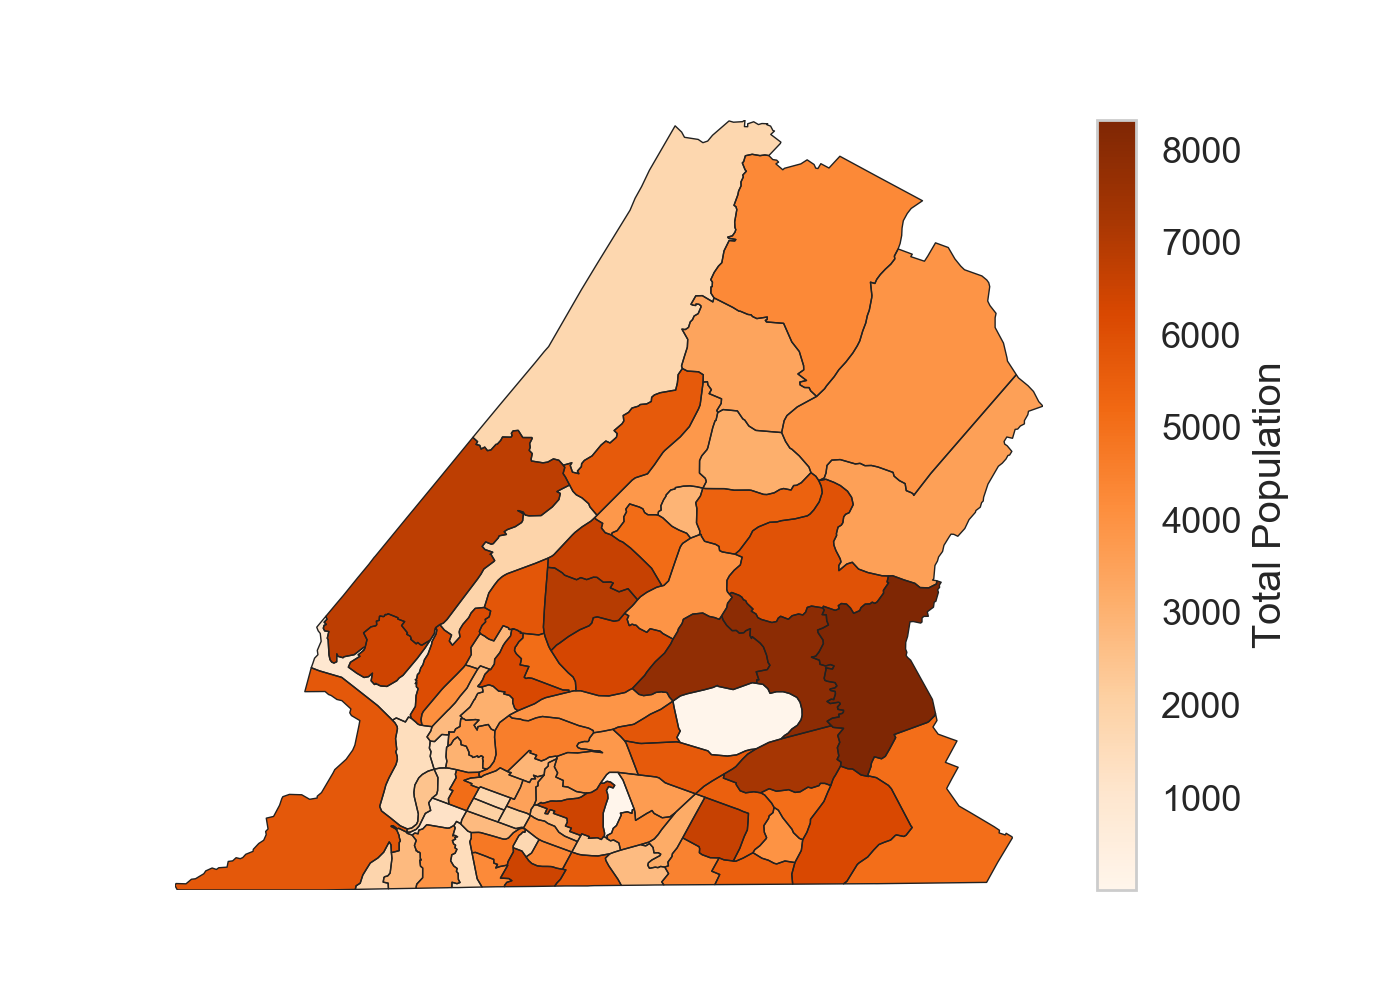

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

pc = PatchCollection(h_merged.poly, zorder=2)
cmap = plt.get_cmap('Oranges')   
norm = Normalize()
pc.set_facecolor(cmap(norm(h_merged['AV0AA2010'].fillna(0).values)))
pc.set_edgecolor("none")
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(h_merged['AV0AA2010'])
cbar = fig.colorbar(mapper, label="Total Population")

pc = PatchCollection(h_merged.poly, zorder=2)
pc.set_edgecolor("#222222")
pc.set_facecolor("none")
pc.set_linewidth(0.5)
ax.add_collection(pc)

ax.set_xlim(ham_lng.min(), ham_lng.max())
ax.set_ylim(ham_lat.min(), ham_lat.max())
plt.axis("off");

Let's make this into a function to make things easier:

In [53]:
def merge_tract_data(df, filename, columns, name_col="NAME2010"):
    """
    Merge the census tract data with a DataFrame containing the shape files.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame containing some form of tract identifier and the 
        shape files for each tract
    
    filename : str
        A path and file name containing the census data.
        
    columns : iterable of ints
        A list of column labels to be read out of the census data file
        and added to the DataFrame with the shape data
        
    name_col : str
        The name of the column used to match tract IDs is not the 
        same in all census data files. If it is not NAME2010, set the 
        different value here.
    
    Returns
    -------
    df_merged : pandas.DataFrame
        A DataFrame containing both the shape information as well as 
        the census data read out of the file in `filename`
    
    """
    pop = pd.read_csv(filename, encoding="ISO-8859-1")
    ten = pop.loc[(pop["STATE"] == "Tennessee") & (pop["COUNTY"] == 'Hamilton County')]
    
    ten.loc[ten.index, "tract int"] = ten["TRACTA"]/100.0    
    
    columns.extend(["tract int"])
    df_merged = pd.merge(df, ten[columns], how='inner', 
                    left_on="name int", right_on="tract int")
    
    print(df_merged.columns)
    df_merged.drop("tract int", axis=1, inplace=True)    
    return df_merged

In [54]:
h_merged = merge_tract_data(h_merged, "../data/nhgis0015_ts_nominal_tract_PersonsUnder18inHousehold.csv",
                            columns=['CQ9AA1970', 'CQ9AA1980', 
                                     'CQ9AA1990', 'CQ9AA2000',
                                     'CQ9AA2010'])

Index(['count', 'geo_id', 'name', 'poly', 'tract', 'name int', 'AV0AA1970',
       'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010', 'AV0AA125',
       'AV0AA125M', 'CQ9AA1970', 'CQ9AA1980', 'CQ9AA1990', 'CQ9AA2000',
       'CQ9AA2010', 'tract int'],
      dtype='object')


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
h_merged.head()

,count,geo_id,name,poly,tract,name int,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA125,AV0AA125M,CQ9AA1970,CQ9AA1980,CQ9AA1990,CQ9AA2000,CQ9AA2010
0,0.985767,1400000US47065001800,18,"Poly((-85.3333, 34.9839) ...)",001800,18.00,4948.0,4188.0,3470.0,3331.0,2741.0,2645.0,355.0,1523.0,1061.0,869.0,826.0,508.0
1,0.684265,1400000US47065010435,104.35,"Poly((-85.275, 35.1764) ...)",010435,104.35,NaN,NaN,NaN,NaN,5817.0,5483.0,464.0,NaN,NaN,NaN,NaN,1012.0
2,0.211169,1400000US47065010501,105.01,"Poly((-85.2655, 35.1287) ...)",010501,105.01,6911.0,7163.0,6359.0,5984.0,6255.0,6521.0,585.0,2594.0,0.0,1342.0,1212.0,1257.0
3,0.752384,1400000US47065001900,19,"Poly((-85.3055, 34.9845) ...)",001900,19.00,8901.0,7515.0,5331.0,4171.0,3959.0,4643.0,549.0,4266.0,2979.0,2039.0,1547.0,1224.0
4,0.408294,1400000US47065010600,106,"Poly((-85.2699, 35.144) ...)",010600,106.00,3440.0,3326.0,3044.0,2965.0,2834.0,2906.0,317.0,907.0,666.0,566.0,554.0,501.0


And we can also do this for the median household income:

In [56]:
med_hh = pd.read_csv("../data/nhgis0017_ts_nominal_tract_MedianHouseholdIncome.csv", 
                     encoding="ISO-8859-1")

In [58]:
med_hh.head()

,NHGISCODE,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2012,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,...,TRACTA,NAME1980,NAME1990,NAME2000,NAME2012,B79AA1980,B79AA1990,B79AA2000,B79AA125,B79AA125M
0,G0100010020100,G01000100201,G01000100201,G0100010020100,G0100010020100,Alabama,1,10,Autauga County,1,...,20100,State: 01 County: 001 Tract: 201,Tract 201,Census Tract 201,"Census Tract 201, Autauga County, Alabama",0.0,27375.0,36685.0,56500.0,12422.0
1,G0100010020200,G01000100202,G01000100202,G0100010020200,G0100010020200,Alabama,1,10,Autauga County,1,...,20200,State: 01 County: 001 Tract: 202,Tract 202,Census Tract 202,"Census Tract 202, Autauga County, Alabama",11360.0,19000.0,30298.0,41250.0,7025.0
2,G0100010020300,G01000100203,G01000100203,G0100010020300,G0100010020300,Alabama,1,10,Autauga County,1,...,20300,State: 01 County: 001 Tract: 203,Tract 203,Census Tract 203,"Census Tract 203, Autauga County, Alabama",18188.0,29419.0,46731.0,43088.0,6197.0
3,G0100010020400,G01000100204,G01000100204,G0100010020400,G0100010020400,Alabama,1,10,Autauga County,1,...,20400,State: 01 County: 001 Tract: 204,Tract 204,Census Tract 204,"Census Tract 204, Autauga County, Alabama",23641.0,37891.0,46142.0,54503.0,3550.0
4,G0100010020500,G01000100205,G01000100205,G0100010020500,G0100010020500,Alabama,1,10,Autauga County,1,...,20500,State: 01 County: 001 Tract: 205,Tract 205,Census Tract 205,"Census Tract 205, Autauga County, Alabama",21663.0,41516.0,58929.0,65027.0,8146.0


In [59]:
h_merged = merge_tract_data(h_merged, "../data/nhgis0017_ts_nominal_tract_MedianHouseholdIncome.csv",
                            columns=['B79AA1980', 'B79AA1990', 
                                     'B79AA2000', 'B79AA125', 
                                     'B79AA125M'])

Index(['count', 'geo_id', 'name', 'poly', 'tract', 'name int', 'AV0AA1970',
       'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010', 'AV0AA125',
       'AV0AA125M', 'CQ9AA1970', 'CQ9AA1980', 'CQ9AA1990', 'CQ9AA2000',
       'CQ9AA2010', 'B79AA1980', 'B79AA1990', 'B79AA2000', 'B79AA125',
       'B79AA125M', 'tract int'],
      dtype='object')


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [60]:
h_merged.head()

,count,geo_id,name,poly,tract,name int,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,...,CQ9AA1970,CQ9AA1980,CQ9AA1990,CQ9AA2000,CQ9AA2010,B79AA1980,B79AA1990,B79AA2000,B79AA125,B79AA125M
0,0.985767,1400000US47065001800,18,"Poly((-85.3333, 34.9839) ...)",001800,18.00,4948.0,4188.0,3470.0,3331.0,...,1523.0,1061.0,869.0,826.0,508.0,11412.0,17373.0,32048.0,43008.0,11054.0
1,0.684265,1400000US47065010435,104.35,"Poly((-85.275, 35.1764) ...)",010435,104.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1012.0,NaN,NaN,NaN,51365.0,6729.0
2,0.211169,1400000US47065010501,105.01,"Poly((-85.2655, 35.1287) ...)",010501,105.01,6911.0,7163.0,6359.0,5984.0,...,2594.0,0.0,1342.0,1212.0,1257.0,21402.0,31808.0,41806.0,52431.0,5921.0
3,0.752384,1400000US47065001900,19,"Poly((-85.3055, 34.9845) ...)",001900,19.00,8901.0,7515.0,5331.0,4171.0,...,4266.0,2979.0,2039.0,1547.0,1224.0,5030.0,6422.0,11509.0,13728.0,3001.0
4,0.408294,1400000US47065010600,106,"Poly((-85.2699, 35.144) ...)",010600,106.00,3440.0,3326.0,3044.0,2965.0,...,907.0,666.0,566.0,554.0,501.0,15874.0,23382.0,32917.0,38456.0,5513.0


And finally, the racial data:

In [61]:
race = pd.read_csv("../data/nhgis0016_ts_nominal_tract_PersonsByRace.csv",
                  encoding="ISO-8859-1")

In [64]:
race.columns

Index(['NHGISCODE', 'GJOIN1970', 'GJOIN1980', 'GJOIN1990', 'GJOIN2000',
       'GJOIN2010', 'STATE', 'STATEFP', 'STATENH', 'COUNTY', 'COUNTYFP',
       'COUNTYNH', 'TRACTA', 'NAME1970', 'NAME1980', 'NAME1990', 'NAME2000',
       'NAME2010', 'B18AA1970', 'B18AA1980', 'B18AA1990', 'B18AA2000',
       'B18AA2010', 'B18AB1970', 'B18AB1980', 'B18AB1990', 'B18AB2000',
       'B18AB2010', 'B18AC1970', 'B18AC1980', 'B18AC1990', 'B18AC2000',
       'B18AC2010', 'B18AD1970', 'B18AD1980', 'B18AD1990', 'B18AD2000',
       'B18AD2010', 'B18AE2000', 'B18AE2010'],
      dtype='object')

In [62]:
race.head()

,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,STATE,STATEFP,STATENH,COUNTY,...,B18AC1990,B18AC2000,B18AC2010,B18AD1970,B18AD1980,B18AD1990,B18AD2000,B18AD2010,B18AE2000,B18AE2010
0,G0100010020100,NaN,G01000100201,G01000100201,G0100010020100,G0100010020100,Alabama,1,10,Autauga County,...,4.0,15.0,14.0,NaN,0.0,16.0,11.0,28.0,21.0,31.0
1,G0100010020200,NaN,G01000100202,G01000100202,G0100010020200,G0100010020200,Alabama,1,10,Autauga County,...,7.0,6.0,5.0,NaN,0.0,13.0,13.0,32.0,25.0,28.0
2,G0100010020300,NaN,G01000100203,G01000100203,G0100010020300,G0100010020300,Alabama,1,10,Autauga County,...,2.0,7.0,11.0,NaN,14.0,19.0,49.0,57.0,31.0,82.0
3,G0100010020400,NaN,G01000100204,G01000100204,G0100010020400,G0100010020400,Alabama,1,10,Autauga County,...,16.0,16.0,11.0,NaN,7.0,32.0,65.0,44.0,22.0,52.0
4,G0100010020500,NaN,G01000100205,G01000100205,G0100010020500,G0100010020500,Alabama,1,10,Autauga County,...,4.0,25.0,48.0,NaN,27.0,36.0,98.0,395.0,70.0,220.0


In [65]:
h_merged = merge_tract_data(h_merged, "../data/nhgis0016_ts_nominal_tract_PersonsByRace.csv",
                            columns=['B18AA1970', 'B18AA1980', 
                                     'B18AA1990', 'B18AA2000',
                                     'B18AA2010', 'B18AB1970', 
                                     'B18AB1980', 'B18AB1990', 
                                     'B18AB2000', 'B18AB2010', 
                                     'B18AC1970', 'B18AC1980', 
                                     'B18AC1990', 'B18AC2000',
                                     'B18AC2010', 'B18AD1970', 
                                     'B18AD1980', 'B18AD1990', 
                                     'B18AD2000', 'B18AD2010', 
                                     'B18AE2000', 'B18AE2010'])

Index(['count', 'geo_id', 'name', 'poly', 'tract', 'name int', 'AV0AA1970',
       'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010', 'AV0AA125',
       'AV0AA125M', 'CQ9AA1970', 'CQ9AA1980', 'CQ9AA1990', 'CQ9AA2000',
       'CQ9AA2010', 'B79AA1980', 'B79AA1990', 'B79AA2000', 'B79AA125',
       'B79AA125M', 'B18AA1970', 'B18AA1980', 'B18AA1990', 'B18AA2000',
       'B18AA2010', 'B18AB1970', 'B18AB1980', 'B18AB1990', 'B18AB2000',
       'B18AB2010', 'B18AC1970', 'B18AC1980', 'B18AC1990', 'B18AC2000',
       'B18AC2010', 'B18AD1970', 'B18AD1980', 'B18AD1990', 'B18AD2000',
       'B18AD2010', 'B18AE2000', 'B18AE2010', 'tract int'],
      dtype='object')


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We want the percentage of non-white persons, so let's calculate that:

In [143]:

def calculate_poc_fraction(h_merged, year):
    col_all = []

    for i in h_merged.index:
        w = h_merged.loc[i, "B18AA"+year]
        c_all = 0.0
        for j in ["B18AA"+year, "B18AA"+year, "B18AC"+year, "B18AD"+year]:
            c = h_merged.loc[i, j]
            if np.isfinite(c):
                c_all += c
            else:
                continue

        if not np.isfinite(w):
            col = 1.0
        if not np.isfinite(c_all):
            col = 0.0
        else:
            col = 1.0 - w/c_all

        col_all.append(col)
    
    h_merged.loc[h_merged.index, "POC"+year] = col_all

    return h_merged

In [144]:
h_merged = calculate_poc_fraction(h_merged, "1970")

In [145]:
h_merged = calculate_poc_fraction(h_merged, "1980")
h_merged = calculate_poc_fraction(h_merged, "1990")
h_merged = calculate_poc_fraction(h_merged, "2000")
h_merged = calculate_poc_fraction(h_merged, "2010")

In [165]:
h_merged = h_merged.replace(np.nan, value="Null")

We're going to have to write all of this as a json file, so we need to make it into dictionaries:

In [149]:
h_merged.columns

Index(['count', 'geo_id', 'name', 'poly', 'tract', 'name int', 'AV0AA1970',
       'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010', 'AV0AA125',
       'AV0AA125M', 'CQ9AA1970', 'CQ9AA1980', 'CQ9AA1990', 'CQ9AA2000',
       'CQ9AA2010', 'B79AA1980', 'B79AA1990', 'B79AA2000', 'B79AA125',
       'B79AA125M', 'B18AA1970', 'B18AA1980', 'B18AA1990', 'B18AA2000',
       'B18AA2010', 'B18AB1970', 'B18AB1980', 'B18AB1990', 'B18AB2000',
       'B18AB2010', 'B18AC1970', 'B18AC1980', 'B18AC1990', 'B18AC2000',
       'B18AC2010', 'B18AD1970', 'B18AD1980', 'B18AD1990', 'B18AD2000',
       'B18AD2010', 'B18AE2000', 'B18AE2010', 'POC1970', 'POC1980', 'POC1990',
       'POC2000', 'POC2010'],
      dtype='object')

In [187]:
h_merged_dict = []

for i in h_merged.index:
    h = h_merged.loc[i]
    poly = list(h["poly"].get_path().vertices)
    poly = [[[list(p) for p in poly]]]
    
    d_geo = {"type": "Feature",
             "geometry": {"coordinates": poly, 
                          "type": "MultiPolygon"},
             "properties": h[['tract', 'name int', 'AV0AA1970','geo_id', 'name', 
                          'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010', 'AV0AA125',
                          'AV0AA125M', 'CQ9AA1970', 'CQ9AA1980', 'CQ9AA1990', 'CQ9AA2000',
                          'CQ9AA2010', 'B79AA1980', 'B79AA1990', 'B79AA2000', 'B79AA125',
                          'B79AA125M', 'B18AA1970', 'B18AA1980', 'B18AA1990', 'B18AA2000',
                          'B18AA2010', 'B18AB1970', 'B18AB1980', 'B18AB1990', 'B18AB2000',
                          'B18AB2010', 'B18AC1970', 'B18AC1980', 'B18AC1990', 'B18AC2000',
                          'B18AC2010', 'B18AD1970', 'B18AD1980', 'B18AD1990', 'B18AD2000',
                          'B18AD2010', 'B18AE2000', 'B18AE2010', 'POC1970', 'POC1980', 
                          'POC1990', 'POC2000', 'POC2010']].to_dict()}
    d_geo["properties"]["poc combined"] = [h["POC1970"], h["POC1980"], h["POC1990"],
                                           h["POC2000"], h["POC2010"]]
    h_merged_dict.append(d_geo)

In [188]:
# write the GeoJSON file
from json import dumps
gjson = open("../data/gz_2010_with_census_data.geojson", "w")
gjson.write(dumps({"type": "FeatureCollection",\
            "features": h_merged_dict}, indent=2) + "\n")


gjson.close()

In [189]:
test_data = geojson.load(open("../data/gz_2010_with_census_data.geojson"))

In [190]:
test_data["features"][0]

{"geometry": {"coordinates": [[[[-85.3332660962799, 34.9839256971312], [-85.3415570769491, 34.9837767448717], [-85.3443820977229, 34.9837259917408], [-85.344591, 34.987187999999996], [-85.34763, 34.987857999999996], [-85.347144, 34.990784], [-85.346452, 34.991279], [-85.345716, 34.991423], [-85.344876, 34.991687], [-85.34464299999999, 34.991932], [-85.344477, 34.992002], [-85.344234, 34.992401], [-85.343352, 34.993472], [-85.343311, 34.993854999999996], [-85.342244, 35.00249], [-85.342601, 35.006108999999995], [-85.340595, 35.006582], [-85.338855, 35.007022], [-85.337795, 35.007329], [-85.337794, 35.012291], [-85.337068, 35.013331], [-85.337237, 35.013906], [-85.337418, 35.014415], [-85.337695, 35.015260999999995], [-85.337847, 35.01668], [-85.339226, 35.019891], [-85.34025799999999, 35.020959], [-85.342779, 35.022323], [-85.342586, 35.022697], [-85.34252699999999, 35.022697], [-85.342106, 35.022644], [-85.341636, 35.022644], [-85.34146899999999, 35.022625999999995], [-85.341386, 35.02